<a href="https://colab.research.google.com/github/javicivit/TPU-UNET/blob/master/TPU_U_Net_Cup_Disc_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train with RIM one and DRISHTI
## TPU based UNET Segmentation.

The colaboratory demostrates  the segmentation of Fundus images using the very well known U-Net network in Keras.
This work is originally based on:
[Sevastopolsky A., Optic disc and cup segmentation methods for glaucoma detection with modification of U-Net convolutional neural network, Pattern Recognition and Image Analysis 27 (2017), no. 3, 618–624](https://github.com/seva100/optic-nerve-cnn )

The code was rewriten and adapted to TPU based trainning by Javier Civit and Anton Civit. The main modifications are:
* We use a completely different dual image generator and use it for both training and testing. For TPU training we need much larger static datasets and, thus we also make use of static data augmentation including images with modified brightness and modified parameters for the adaptive histogram equalization. This, together with the use of images from three different publicly available datasets for training and validation improves the robustness to the use if images acquired with different instruments.
* We use the version of Keras included in tensorflow. This is necessary to be able to execute in TPUs.
* We use [Pröve's parameterizable recursive U-net model](https://github.com/pietz/unet-keras). This model allows us to easily change many parameters necessary to compare different implementations of U-Net. Specifically, we can change the network depth and with, the use of drop out and batch normalization, the use of upsampling (although this type of layer is not currently supported by Keras in TPUs) nor transpose convolution and the width ratio between successive layers
* We use 120 image batches for both training and testing and train for 15 epochs using 150 training steps and 30 testing steps per epoch. We use an Adam optimizer algorithm in most cases with a .00075 learning rate although in a few cases, we have had to lower this value to ensure convergence. This values have proven suitable for TPU based training in U-Net architecture and provide good results with training times bellow 20 minutes even in the most complex implementations.




### Training of a modified U-Net for Optic Disc/Cup on RIM-ONE v3  & DRISHTI databases.

We use publicly available RIM-ONE v3, DRISHTI and DRIONS datasets. The use of multiple datasets both for training and for validation allows our system to be more independent of the capture devices than other available implementations. RIM ONE-v3, from the MIAG group of the University of La Laguna (Spain), consists of 159 fundus images which have been labeled by expert ophthalmologists for both disc and cup. DRISHTI-GS, from Aravind Eye hospital, Madurai, India consists of 101 fundus images also labeled for disc and cup. DRIONS-DB from Miguel Servet Hospital, Saragossa (Spain), consists of 110 images on which only the optic cup has been labelled.
Fundus images and disk maskks are resized in one sted to 128x128.  The hdf versions of the Datasets can be uploaded from [Sevastopolsky's github](https://github.com/seva100/optic-nerve-cnn)



####Lets load the data from Gdrive
We will use the colab interface to google drive. See: https://colab.research.google.com/notebooks/io.ipynb 


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


Colab drive only allows file open, read and write thus we define our own copy function:

In [0]:
def copy( fs,fd):
  f1=open(fs,'rb')
  
  fs_c=f1.read()
  f2=open(fd,'w+b')
  f2.write(fs_c)
  f1.close()
  
  
  f2.close()

In [0]:
copy('/content/gdrive/My Drive/RIM_ONE_v3.hdf5','/content/RIM_ONE_v3.hdf5')
copy('/content/gdrive/My Drive/DRIONS_DB.hdf5','/content/DRIONS_DB.hdf5')
copy('/content/gdrive/My Drive/DRISHTI_GS.hdf5','/content/DRISHTI_GS.hdf5')

In [0]:
!ls -l  '/content'

total 1172852
-rw-r--r-- 1 root root  92753979 May 29 12:37 DRIONS_DB.hdf5
-rw-r--r-- 1 root root 630916755 May 29 12:37 DRISHTI_GS.hdf5
drwx------ 3 root root      4096 May 29 12:36 gdrive
-rw-r--r-- 1 root root 477303151 May 29 12:37 RIM_ONE_v3.hdf5
drwxr-xr-x 1 root root      4096 May 24 16:08 sample_data


Let's import the required libraries:

In [0]:

import tensorflow as tf


import os
import glob
from datetime import datetime
#import warnings
#warnings.simplefilter('ignore')
import scipy as sp
import scipy.ndimage
import numpy as np
import pandas as pd
import skimage
import skimage.exposure
import skimage.transform
import skimage.measure
#from sklearn.cross_validation import KFold
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import h5py
from tqdm import tqdm_notebook
#import mahotas as mh
from IPython.display import display
#from dual_IDG import DualImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers as layers
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, \
    Conv2D, MaxPooling2D, ZeroPadding2D, Input, Embedding, LSTM,  \
    Lambda, UpSampling2D,concatenate,Conv2DTranspose
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import SGD, Adam, Adagrad
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import math

In [0]:

K.set_floatx('float32')

Our loss function is based on dice (intersectionover union).
We use -log(dice) as our loss function as this seems to work better but, of course you can play with it.
This is based on: https://github.com/EdwardTyantov/ultrasound-nerve-segmentation 

In [0]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())
  
def dice_loss(y_true,y_pred):
    return -dice_coef(y_true,y_pred)
  
def log_dice_loss(y_true, y_pred):
    return -K.log(dice_coef(y_true, y_pred))

In [0]:
def iou_loss_core(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true,-1) + K.sum(y_pred,-1) - intersection
    iou = (intersection + smooth) / ( union + smooth)
    return iou

Auxiliary function to modify image brightness.

In [0]:
def modify_brightness_p(img, p=1.2):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 1.0/p
    v[v > lim] = 1.0
    v[v <= lim] *= p
    #print(np.amax(v))

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR).clip(min=0)
    return img

Auxiliary funtion to shuffle to vectors in a coherent way:

In [0]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

Auxiliary function to use 512 image size indexes with original images.

In [0]:
def index512_resize(index,top):
  index=index*top/512
  return int(index)

Our data is in hdf5 (https://www.h5py.org/) format
Train/test with  Drishti and RimONE

In [0]:
#h5f1 = h5py.File(os.path.join(os.path.dirname(os.getcwd()), 'content', 'all_data.hd5f'), 'r')
h5f1 = h5py.File(os.path.join(os.path.dirname(os.getcwd()), 'content', 'RIM_ONE_v3.hdf5'), 'r')

In [0]:
h5f2=h5py.File(os.path.join(os.path.dirname(os.getcwd()), 'content', 'DRISHTI_GS.hdf5'), 'r')

In [0]:
h5v1=h5py.File(os.path.join(os.path.dirname(os.getcwd()), 'content', 'DRIONS_DB.hdf5'), 'r')

### U-Net architecture

We use a version of the net presented in: https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/ 
The generalized U-Net is based on https://github.com/pietz/unet-keras

In [0]:
'''
U-Net: Convolutional Networks for Biomedical Image Segmentation
(https://arxiv.org/abs/1505.04597)
---
img_shape: (height, width, channels)
out_ch: number of output channels
start_ch: number of channels of the first conv
depth: zero indexed depth of the U-structure
inc_rate: rate at which the conv channels will increase
activation: activation function after convolutions
dropout: amount of dropout in the contracting part
batchnorm: adds Batch Normalization if true
maxpool: use strided conv instead of maxpooling if false
upconv: use transposed conv instead of upsamping + conv if false
residual: add residual connections around each conv block if true
'''

def conv_block(m, dim, acti, bn, res, do=0):
	n = Conv2D(dim, 3, activation=acti, padding='same')(m)
	n = BatchNormalization()(n) if bn else n
	n = Dropout(do)(n) if do else n
	n = Conv2D(dim, 3, activation=acti, padding='same')(n)
	n = BatchNormalization()(n) if bn else n
	return Concatenate()([m, n]) if res else n

def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res):
	if depth > 0:
		n = conv_block(m, dim, acti, bn, res)
		m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
		m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res)
		if up:
			m = UpSampling2D()(m)
			m = Conv2D(dim, 2, activation=acti, padding='same')(m)
		else:
			m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
		n = concatenate([n, m],axis=-1)
		m = conv_block(n, dim, acti, bn, res)
	else:
		m = conv_block(m, dim, acti, bn, res, do)
	return m

def UNet(img_shape, out_ch=1, start_ch=64, depth=4, inc_rate=2., activation='relu', 
		 dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=False):
	i = Input(shape=img_shape)
	o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
	o = Conv2D(out_ch, 1, activation='sigmoid')(o)
	return Model(inputs=i, outputs=o)


Change these parameters according to  the architecture . Uss Cup=True to segment the Cup and False to segment the disk.

In [0]:
img_shape=(128,128,3)

In [0]:
cup=True
name='CUPa05d6w72ir12bn'
model=UNet(img_shape,start_ch=72,upconv=False,dropout=0.65, depth=6,inc_rate=1.2, batchnorm=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Lets visualize the model and save its graphical representation.

In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 72) 2016        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 128, 128, 72) 288         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 72) 46728       batch_normalization_v1[0][0]     
__________________________________________________________________________________________________
batch_norm

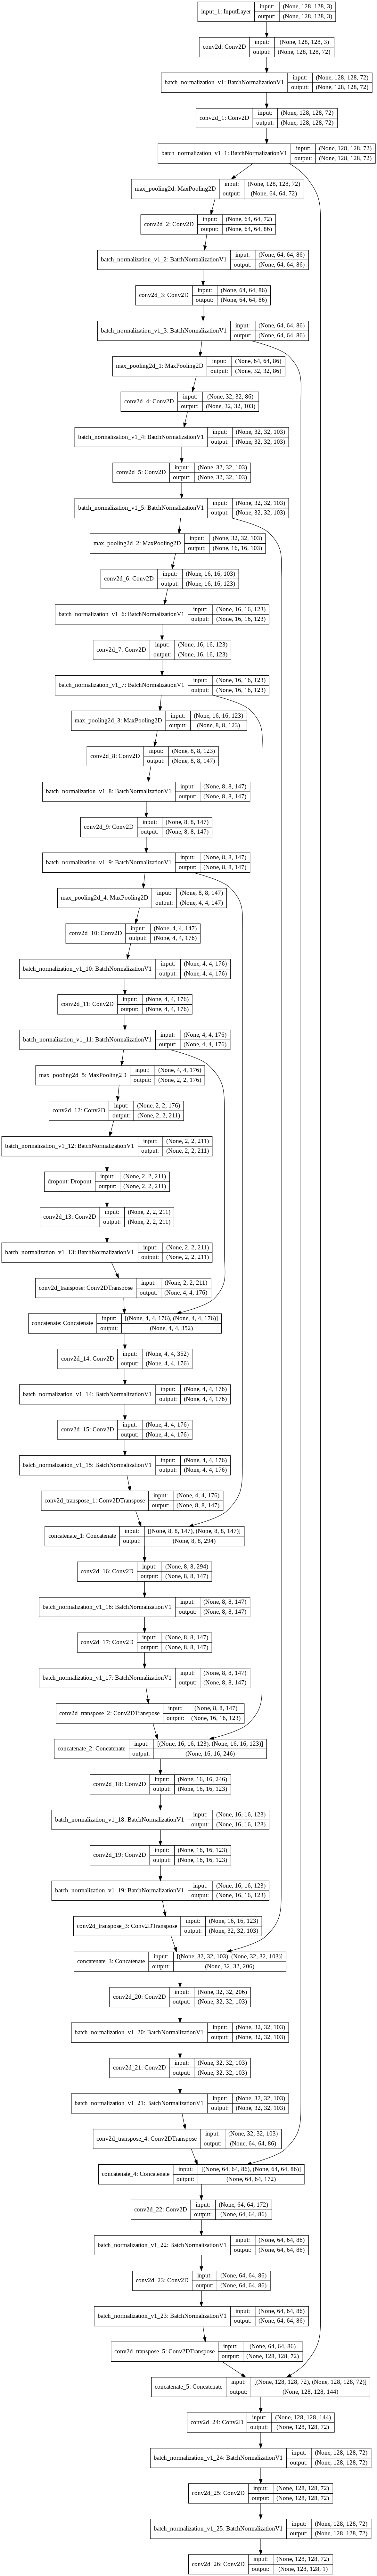

In [0]:
# Plot model graph
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')

In [0]:
copy ('/content/model.png','/content/gdrive/My Drive/model_CE5an.png')

We are using the Adan optimizer https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/ .

In [0]:

arch_name='Cup'
weights_folder = os.path.join(os.path.dirname(os.getcwd()), 'models_weights',
                              '{},{}'.format(datetime.now().strftime('%d.%m,%H:%M'), arch_name))

def folder(folder_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    return folder_name
  
weights_folder


'/models_weights/29.05,12:38,Cup'

**DRISHTI RIM ONE CUP Aggressive augmentation**

Accessing data, preparing train/validation sets: Resize & Prepare

In [0]:
Xori= h5f2['DRISHTI-GS/orig/images']
disc_locations = h5f2['DRISHTI-GS/512 px/disc_locations']
isize=Xori.shape[1]

if(cup):
  Yf = h5f2['DRISHTI-GS/512 px/cup']
  Xc = [Xori[i][index512_resize(disc_locations[i][0],isize):index512_resize(disc_locations[i][2],isize), index512_resize(disc_locations[i][1],isize):index512_resize(disc_locations[i][3],isize)] 
                   for i in range(len(Xori))]

  Yc=[Yf[i][disc_locations[i][0]:disc_locations[i][2], disc_locations[i][1]:disc_locations[i][3]] 
                   for i in range(len(Xori))]
else:
  Yf = h5f2['DRISHTI-GS/512 px/disc']
  Xc = [Xori[i][index512_resize(50,isize):index512_resize(462,isize), index512_resize(50,isize):index512_resize(462,isize)] 
                   for i in range(len(Xori))]

  Yc=[Yf[i][50:462,50:462] 
                   for i in range(len(Xori))]

Xa=[cv2.resize(img, (128, 128),interpolation=cv2.INTER_NEAREST) for img in Xc]
X=[skimage.exposure.equalize_adapthist(img, clip_limit=0.035)  for img in Xa]
X=np.asarray(X) 
am=np.amax(X)
X=X.astype(np.float32)/am 
print(np.amax(X),np.amin(X))

Y=[cv2.resize(img, (128, 128),interpolation=cv2.INTER_NEAREST)[..., None] for img in Yc]
Y=np.asarray(Y) 
ym=np.amax(Y) 
Yf=Y/ym 
Yb=(Y>0.5).astype(np.float32) #get binary mask


print(np.amax(Yf),np.amin(Yf))
print(X.shape)

/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


1.0 0.0
1.0 0.0
(50, 128, 128, 3)


In [0]:
Xvori= h5f1['RIM-ONE v3/orig/images']
disc_locationsv = h5f1['RIM-ONE v3/512 px/disc_locations']
ivsize=Xvori.shape[1]
if (cup):
  Yvf = h5f1['RIM-ONE v3/512 px/cup']
  Xvc = [Xvori[i][index512_resize(disc_locationsv[i][0],ivsize):index512_resize(disc_locationsv[i][2],ivsize), index512_resize(disc_locationsv[i][1],ivsize):index512_resize(disc_locationsv[i][3],ivsize)] 
                     for i in range(len(Xvori))]

  Yvc=[Yvf[i][disc_locationsv[i][0]:disc_locationsv[i][2], disc_locationsv[i][1]:disc_locationsv[i][3]] 
                     for i in range(len(Xvori))]

else:
  Yvf = h5f1['RIM-ONE v3/512 px/disc']
  Xvc = [Xvori[i][index512_resize(50,isize):index512_resize(462,ivsize), index512_resize(50,isize):index512_resize(462,ivsize)] 
                     for i in range(len(Xvori))]

  Yvc=[Yvf[i][50:462,50:462] 
                     for i in range(len(Xvori))]


Xvn=[cv2.resize(img, (128, 128),interpolation=cv2.INTER_NEAREST) for img in Xvc]
Xv=[skimage.exposure.equalize_adapthist(img, clip_limit=0.035)  for img in Xvn]

Xv=np.asarray(Xv) 
am=np.amax(Xv)
Xv=Xv.astype(np.float32)/am 
print(np.amax(Xv),np.amin(Xv))

Yv=[cv2.resize(img, (128, 128),interpolation=cv2.INTER_NEAREST)[..., None] for img in Yvc]

Yv=np.asarray(Yv) 
ym=np.amax(Yv) 
Yvf=(Yv/ym).astype(np.float32) 
print(np.amax(Yvf),np.amin(Yvf))
print(Xv.shape)

/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


1.0 0.0
1.0 0.0
(159, 128, 128, 3)


Create more "data". Just copy the vectors over themselves and add modified versions so that the generators can  produce longer batches & Distibute between train & test

In [0]:
rng = np.random.RandomState(42)
#X=np.concatenate([X,Xv])
#Yf=np.concatenate([Yf,Yvf])
  
X_train1t, X_test1t, Y_train1t, Y_test1t = train_test_split( X, Yb, test_size=0.25,random_state=rng)
X_train2, X_test2, Y_train2, Y_test2 = train_test_split( Xv, Yvf, test_size=0.25,random_state=rng)

X_train1=np.concatenate([X_train1t,X_train1t])
X_train1=np.concatenate([X_train1,X_train1t])
X_test1=np.concatenate([X_test1t,X_test1t])
X_train1=np.concatenate([X_test1,X_test1t])

Y_train1=np.concatenate([Y_train1t,Y_train1t])
Y_train1=np.concatenate([Y_train1,Y_train1t])
Y_test1=np.concatenate([Y_test1t,Y_test1t])
Y_train1=np.concatenate([Y_test1,Y_test1t])

X_train1=np.concatenate([X_train1,X_train2])
Y_train1=np.concatenate([Y_train1,Y_train2])
X_test=np.concatenate([X_test1,X_test2])
Y_test=np.concatenate([Y_test1,Y_test2])

X_train1=np.asarray(X_train1)
Y_train1=np.asarray(Y_train1)
X_test=np.asarray(X_test)
Y_test=np.asarray(Y_test)

X_train=np.copy(X_train1)
Y_train=np.copy(Y_train1)

size=X_train1.shape[0]

X_traine=np.empty((3160, 128, 128, 3),dtype=np.float32)
Y_traine=np.empty((3160, 128, 128, 1),dtype=np.float32)



for i in range(16):
  #print(i*size,(i+1)*size)
  X_traine[i*size:(i+1)*size]=X_train1
  Y_traine[i*size:(i+1)*size]=Y_train1
  
base= 16*size

for j in tqdm_notebook(range(X_train1.shape[0])):
  X_traine[base]=skimage.exposure.equalize_adapthist(X_train1[j], clip_limit=0.4)
  Y_traine[base]=Y_train1[j]
  base+=1
  X_traine[base]=skimage.exposure.equalize_adapthist(X_train1[j], clip_limit=0.2)
  Y_traine[base]=Y_train1[j]
  base+=1
  X_traine[base]=modify_brightness_p(X_train1[j],0.9)
  Y_traine[base]=Y_train1[j]
  base+=1
  X_traine[base]=modify_brightness_p(X_train1[j],1.1)
  Y_traine[base]=Y_train1[j]
  base+=1
  
X_testc=np.copy(X_test)
Y_testc=np.copy(Y_test)

sizev=X_testc.shape[0]

X_teste=np.empty((792, 128, 128, 3),dtype=np.float32)
Y_teste=np.empty((792, 128, 128, 1),dtype=np.float32)

for i in range(8):
  X_teste[i*sizev:(i+1)*sizev]=X_testc
  Y_teste[i*sizev:(i+1)*sizev]=Y_testc
  
basev= 8*sizev

for j in tqdm_notebook(range(X_testc.shape[0])):
  X_teste[basev]=skimage.exposure.equalize_adapthist(X_testc[j], clip_limit=0.4)
  Y_teste[basev]=Y_testc[j]
  basev+=1
  X_teste[basev]=skimage.exposure.equalize_adapthist(X_testc[j], clip_limit=0.2)
  Y_teste[basev]=Y_testc[j]
  basev+=1
  X_teste[basev]=modify_brightness_p(X_testc[j],0.9)
  Y_teste[basev]=Y_testc[j]
  basev+=1
  X_teste[basev]=modify_brightness_p(X_testc[j],1.1)
  Y_teste[basev]=Y_testc[j]
  basev+=1
  
 

/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to float32
  .format(dtypeobj_in, dtypeobj_out))


In [0]:
print(X_traine.shape,Y_traine.shape,X_teste.shape,Y_teste.shape)

(3160, 128, 128, 3) (3160, 128, 128, 1) (792, 128, 128, 3) (792, 128, 128, 1)


***Aumented dual image generator***
Based on the example at:
https://keras.io/preprocessing/image/#imagedatagenerator-class 
Had to modified as zipped version is currently not accepted

In [0]:
X_trains,Y_trains=unison_shuffled_copies(X_traine, Y_traine)

In [0]:
X_tests,Y_tests=unison_shuffled_copies(X_teste, Y_teste)

In [0]:
# Provide the same seed and keyword arguments to the fit and flow methods
seed=42
batch_s=120
#batch_s=96 #conv_Trans will not run in GPU with 128

In [0]:
data_gen_args = dict(#rescale=1./255,
                     #featurewise_center=True,
                     #featurewise_std_normalization=True,
                     horizontal_flip=True, vertical_flip=True,
                     rotation_range=30,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2,
                     fill_mode='constant', cval=0.0, 
                     #brightness_range=[-0.1,0.1],
                     #preprocessing_function=skimage.exposure.equalize_adapthist,
                     dtype='float32'
                     )
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

image_generator = image_datagen.flow(
    X_trains,
    batch_size=batch_s,
    seed=seed)

mask_generator = mask_datagen.flow(
    Y_trains,
    batch_size=batch_s,
    seed=seed)

#train_generator = zip(image_generator, mask_generator)
def train_generator():
  while True:
    yield image_generator.next(),mask_generator.next()
    

image_generator_test = image_datagen.flow(
    X_tests,
    batch_size=batch_s,
    seed=seed)

mask_generator_test = mask_datagen.flow(
    Y_tests,
    batch_size=batch_s,
    seed=seed)

#test_generator = zip(image_generator_test, mask_generator_test)
def test_generator():
  while True:
    yield image_generator_test.next(),mask_generator_test.next()

Set the place for localy saving the weights. After training we will copy to Gdrive

In [0]:
weights_folder = os.path.join(os.path.dirname(os.getcwd()), 'models_weights')

def folder(folder_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    return folder_name
  
weights_folder


'/models_weights'

###Train on TPU (DO not exec on GPU)

In [0]:
#This address identifies the TPU we'll use when configuring TensorFlow.
TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']

In [0]:
tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(tpu=TPU_WORKER),
        using_single_core=False
    )
)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Querying Tensorflow master (grpc://10.72.66.194:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 1177549281950124853)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 5674967088841022202)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 14527580332019940193)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1

In [0]:
tpu_model.compile(
    #optimizer=tf.train.AdagradOptimizer(learning_rate=0.05 ),
    #loss = 'binary_crossentropy', metrics = ['accuracy']
    #optimizer=SGD(lr=3e-4, momentum=0.95), 
    #optimizer=tf.train.Adagrad(),
    optimizer=tf.train.AdamOptimizer(learning_rate=0.00075 ),
    loss=log_dice_loss, metrics=[dice_coef]
)

In [0]:
%%time 
history=tpu_model.fit_generator(
                           train_generator(),
                           steps_per_epoch = 150,
                           validation_data = test_generator(),
                           validation_steps = 30,
                           epochs=15           
)

Epoch 1/15
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(15,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(15, 128, 128, 3), dtype=tf.float32, name='input_1_10'), TensorSpec(shape=(15, 128, 128, 1), dtype=tf.float32, name='conv2d_26_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 26.441848516464233 secs
INFO:tensorflow:Setting weights on TPU model.
 26/150 [====>.........................] - ETA: 6:25 - loss: 0.4831 - dice_coef: 0.6400INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(5,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(5, 128, 128, 3), dtype=tf.float32, name='input_1_10'), TensorSpec(shape=(5, 128, 128, 1), dtype=tf.float32, name='conv2d_26_target_10')]
INFO:tensorflow:Ove

In [0]:
#cpu_model = tpu_model.sync_to_cpu()

In [0]:
tpu_model.save(os.path.join(folder(weights_folder),'last_checkpoint_TPU.hdf5'))

INFO:tensorflow:Copying TPU weights to the CPU


Save weights on Gdrive. Ajust destination File as desired

In [0]:
copy(os.path.join(folder(weights_folder),'last_checkpoint_TPU.hdf5'),os.path.join('/content/gdrive/My Drive/TPU',name+'.hdf5'))

**Chart Accuracy and Loss**

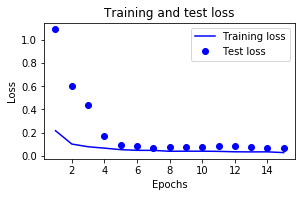

In [0]:
loss = history.history['loss']
val_loss=history.history['val_loss']
acc=history.history['dice_coef']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(4.5, 2.5))
plt.plot(epochs, loss, 'b', label='Training loss')
# bo is blue dots
plt.plot(epochs, val_loss, 'bo', label='Test loss')
# b is for "solid blue line"
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

#plt.show()
plt.savefig(os.path.join('/content/gdrive/My Drive/FIG','loss'+name+'.png'),dpi=600)


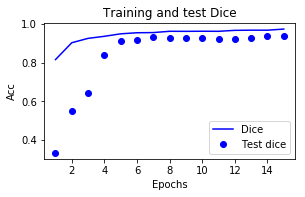

In [0]:
import matplotlib.pyplot as plt

loss = history.history['loss']
acc=history.history['dice_coef']
val_acc=history.history['val_dice_coef']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(4.5, 2.5))
plt.plot(epochs, acc, 'b', label='Dice')
# bo is blue dots
plt.plot(epochs, val_acc, 'bo', label='Test dice')
# b is for "solid blue line"
plt.title('Training and test Dice')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

#plt.show()
plt.savefig(os.path.join('/content/gdrive/My Drive/FIG','hist'+name+'.png'),dpi=600)

### Comprehensive visual check

In [0]:
test_s=int(X_testc.shape[0])
test_s=test_s-test_s%8
test_s

64

In [0]:
smooth=1e-07

def np_dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return ( (2. * intersection + smooth) / 
             (np.sum(y_true_f) + np.sum(y_pred_f) + smooth) )

In [0]:
def np_iou(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return ( ( intersection + smooth) / 
             (np.sum(y_true_f) + np.sum(y_pred_f) - intersection + smooth) )
  
  
  
    

Acquiring scores for the validation set:

(64, 128, 128, 3)



Dice mean= 0.8967086  Std= 0.106810756  best= 0.9916747  worst= 0.51956874
IOU mean= 0.8280991  Std= 0.15939996  best= 0.9834869  worst= 0.3509577
image #2
0.9916747
image #58
0.51956874
CPU times: user 5.11 s, sys: 493 ms, total: 5.61 s
Wall time: 5.16 s


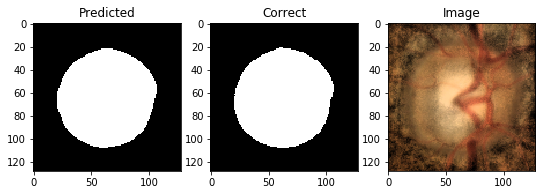

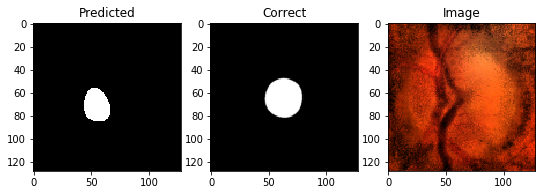

In [0]:
%%time
pred_dice=np.empty((test_s), dtype=np.float32)
pred_iou=np.empty((test_s), dtype=np.float32)


#sess = K.get_session()

batch_X = X_testc[0:test_s]
batch_y = Y_testc[0:test_s]
print (batch_X.shape)
    
predv = (tpu_model.predict(batch_X)[...,0]>0.5).astype(np.float32)
corrv= (batch_y)[ ..., 0].astype(np.float32)


for i in tqdm_notebook(range(predv.shape[0])):
    #print('image #{}'.format(i))
    img = X_test[i]
    
    pred = predv[i]
    corr = corrv[i]
    cur_dice = np_dice_coef(pred, corr)
    cur_iou = np_iou(pred,corr)
    #print(cur_dice)
    pred_dice[i]=(cur_dice)
    pred_iou[i]=cur_iou
    
    
d_worst=np.amin(pred_dice)
d_best=np.amax(pred_dice)
d_mean=np.mean(pred_dice)
d_std=np.std(pred_dice)
print("Dice mean=",d_mean, " Std=",d_std, " best=",d_best," worst=",d_worst)

i_worst=np.amin(pred_iou)
i_best=np.amax(pred_iou)
i_mean=np.mean(pred_iou)
i_std=np.std(pred_iou)
print("IOU mean=",i_mean, " Std=",i_std, " best=",i_best," worst=",i_worst)

ix_best=np.argmax(pred_dice)
ix_worst=np.argmin(pred_dice)

j=0
for i in [ix_best,ix_worst]:
    print('image #{}'.format(i))
    img = X_test[i]
    pred = predv[i]
    corr = corrv[i]
    
    print(pred_dice[i])
    fig = plt.figure(figsize=(9, 4))
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(pred, cmap=plt.cm.Greys_r)
    ax.set_title('Predicted')
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(corr, cmap=plt.cm.Greys_r)
    ax.set_title('Correct')
    ax = fig.add_subplot(1, 3, 3)
    #ax.imshow(img)
    ax.imshow(img)
    ax.set_title('Image')
    #plt.show()
    fig.savefig(os.path.join('/content/gdrive/My Drive/FIG','img'+str(j)+name+'.png'),dpi=600)
    j+=1
    


In [0]:
%%time

batch_X = X_testc[0:test_s]
batch_y = Y_testc[0:test_s]
print (batch_X.shape)
    
predv = (tpu_model.predict(batch_X)[...,0]>0.5).astype(np.float32)
corrv= (batch_y)[ ..., 0].astype(np.float32)

(64, 128, 128, 3)
CPU times: user 73.4 ms, sys: 31 ms, total: 104 ms
Wall time: 219 ms


In [0]:
cup_rr= np.empty((test_s), dtype=np.float32)
cup_dc= np.empty((test_s), dtype=np.float32)
cup_ac= np.empty((test_s), dtype=np.float32)
cup_ap= np.empty((test_s), dtype=np.float32)


predc = predv[0, ...].copy()
corrc= corrv[0, ...].copy()
print (predc.shape)

for i in tqdm_notebook(range(test_s), leave=True):
    
    predc = predv[i]
    corrc = corrv[i]
    
    label_pc = skimage.measure.label(predc, connectivity=predc.ndim)
    props_pc = skimage.measure.regionprops(label_pc)
    
    label_cc = skimage.measure.label(corrc, connectivity=corrc.ndim)
    props_cc = skimage.measure.regionprops(label_cc)
    
    sz=len(props_pc)
    if(sz)!=0:
      areap=[props_pc[i].area for i in range(sz)]
      #print(sz,areap)
      k=np.argmax(areap)
    
      xcp = props_pc[k].centroid[0] #x center
      ycp = props_pc[k].centroid[1] #y_center
      ap = props_pc[k].area
    else:
      xpc=0
      ypc=0
      ac=0
    
    xcc = props_cc[0].centroid[0] #x center
    ycc = props_cc[0].centroid[1] #y_center
    ac = props_cc[0].area


    
    if (ap>ac):
      ar=ac/ap
    else:
      ar=ap/ac
      
    dist=math.sqrt((xcp-xcc)*(xcp-xcc)+(ycp-ycc)*(ycp-ycc))
    cup_rr[i]=math.sqrt(ar)
    cup_dc[i]=dist
    cup_ac[i]=ac
    cup_ap[i]=ap

(128, 128)


In [0]:
#print(cup_rr)
#print(cup_dc)
print('best radii ratio= {:0.2f}, worst radii ratio= {:0.2f}, worst center distance= {:0.2f}, best center distance= {:0.2f}'.format(np.amax(cup_rr),np.amin(cup_rr),np.amax(cup_dc),np.amin(cup_dc)))
bt90=cup_rr>.9
print('Percentage of images with less than 10% radius error ={:0.2f}'.format(sum(bt90)/test_s))

best radii ratio= 1.00, worst radii ratio= 0.72, worst center distance= 14.41, best center distance= 0.02
Percentage of images with less than 10% radius error =0.72


(64, 128, 128)


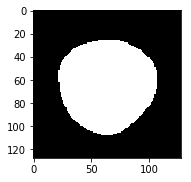

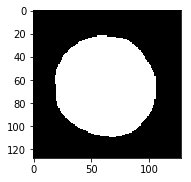

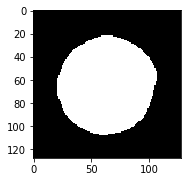

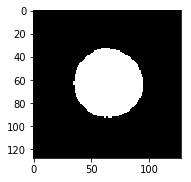

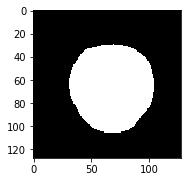

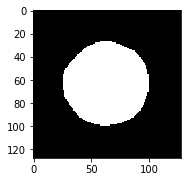

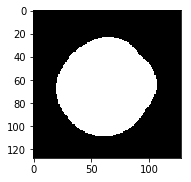

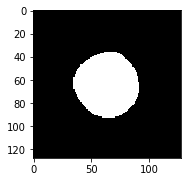

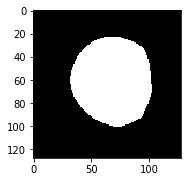

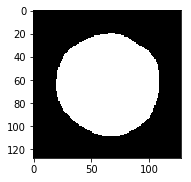

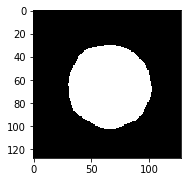

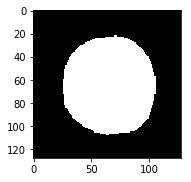

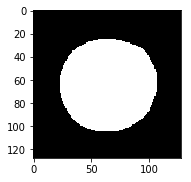

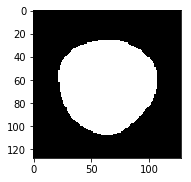

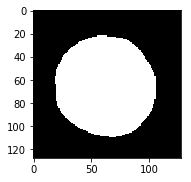

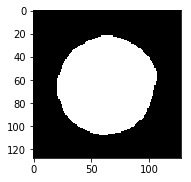

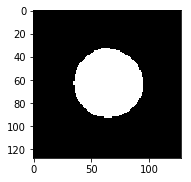

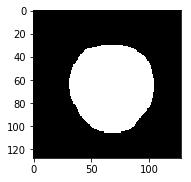

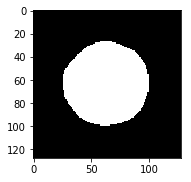

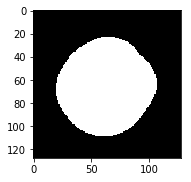

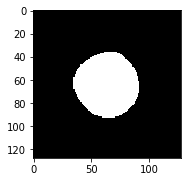

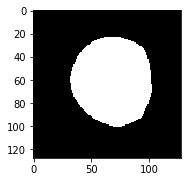

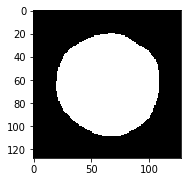

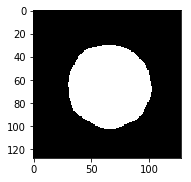

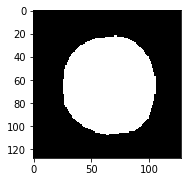

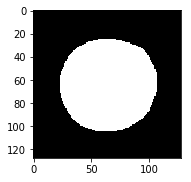

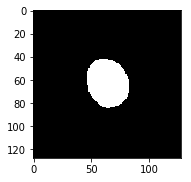

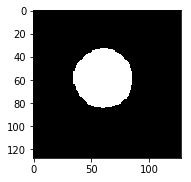

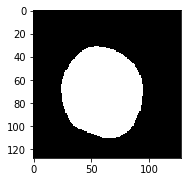

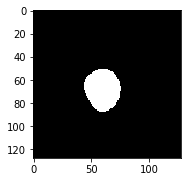

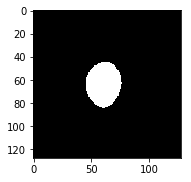

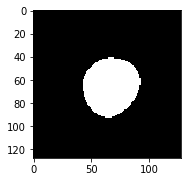

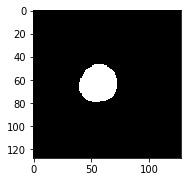

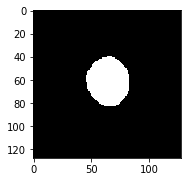

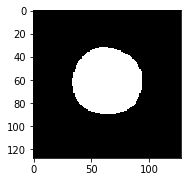

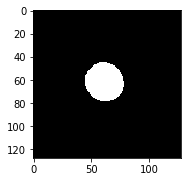

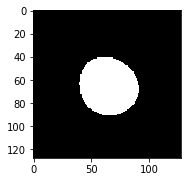

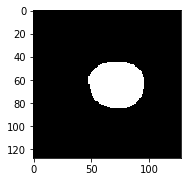

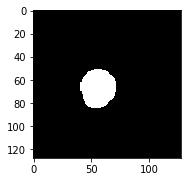

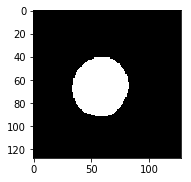

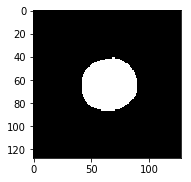

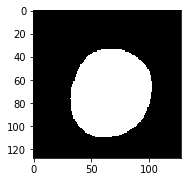

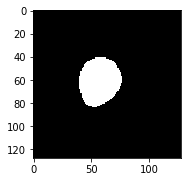

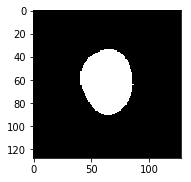

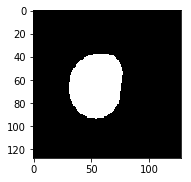

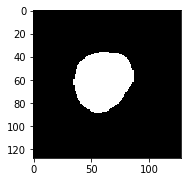

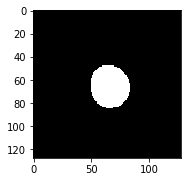

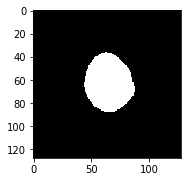

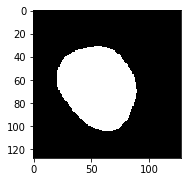

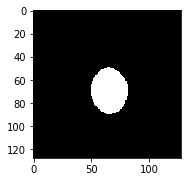

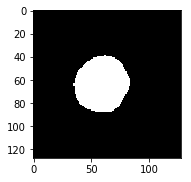

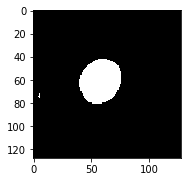

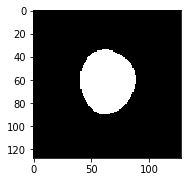

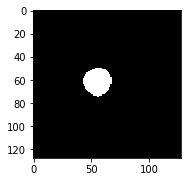

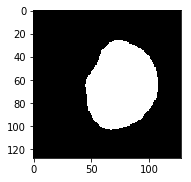

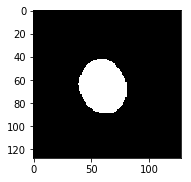

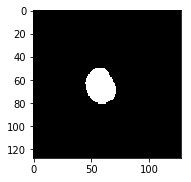

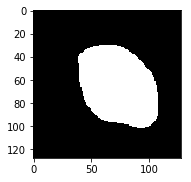

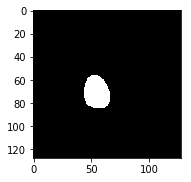

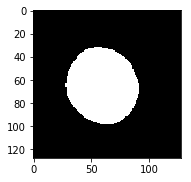

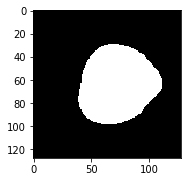

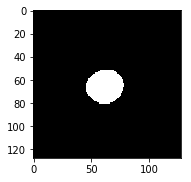

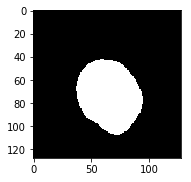

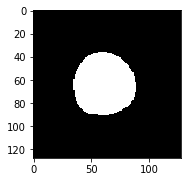

In [0]:
print(predv.shape)
for i in range(predv.shape[0]):
    fig = plt.figure(figsize=(9, 4))
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(predv[i], cmap=plt.cm.Greys_r)
    plt.show()

###Validation DRIons



```
**No cup data available**

---

```

### Loading model 
Ajust files as needed

In [0]:
breakpoint

NameError: ignored

In [0]:
copy('/content/gdrive/My Drive/TPU/'+name+'.hdf5','/content/last_checkpoint.hdf5')
tpu_model.load_weights('/content/last_checkpoint.hdf5','/content/last_checkpoint.hdf5')
    
